# [ET-287] Projeto 4: Identificação de alvos em sinais de radar

## Aluno: Lucas Silva Lima (2º COMP)

##### Importação de bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Lambda, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

2024-05-28 15:57:35.902198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 15:57:37.148329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Desenvolvimento e Questões

- ### 1) Leia o [trabalho de referência](https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-rsn.2019.0307)

- ### 2) Baixe a [base de dados](). Esta base contém amostras de sinais de radar adquiridas em cenários externos reais. A base apresenta três classes de objetos: drones, carros e pessoas.

In [2]:
DIR = './data'
CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []
list_of_img = []
list_of_classis = []

for root, dirs, files in os.walk(DIR):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('/')
            if tmp[-2] in CLASS:
                list_of_classis.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('/'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file))
                list_of_img.append(df.values)

X = np.array(list_of_img)
y = np.array(list_of_classis)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

34970 files loaded.


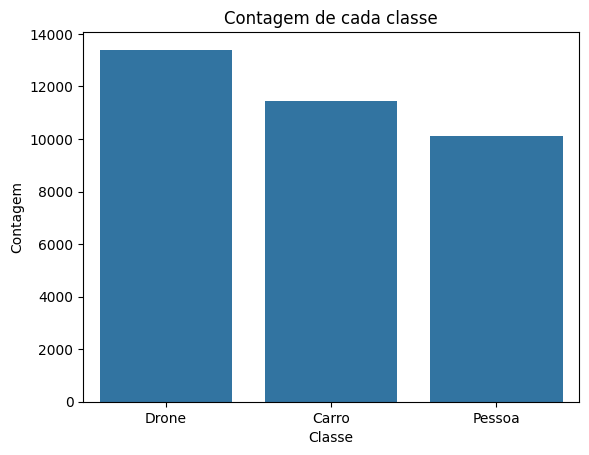

In [3]:
contagem = pd.Series(list_of_classis).value_counts()

classes = ['Drone', 'Carro', 'Pessoa']
dados = pd.DataFrame({'Classe': classes, 'Contagem': contagem})

plt.figure()
sns.barplot(x='Classe', y='Contagem', data=dados)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Contagem de cada classe')
plt.show()

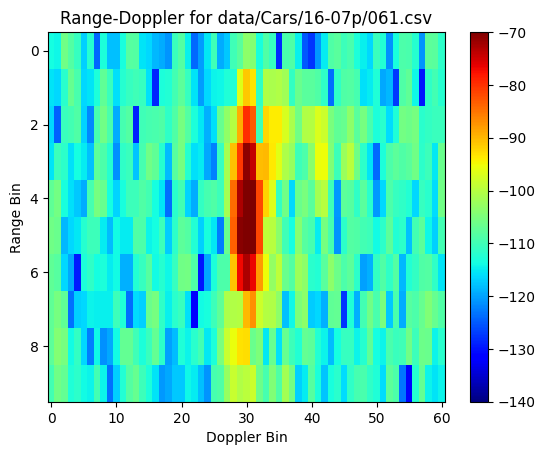

In [4]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[0], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[0]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

- ### 3) Divida os dados em conjuntos de treinamento, validação e teste.

In [5]:
X = X.reshape(-1, 10, 61, 1)

In [6]:
y = to_categorical(y)

In [7]:
X_train, _X, y_train, _y = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(_X, _y, test_size=0.5, random_state=42)

- ### 4) Implemente uma CNN capaz de processar os dados de radar de alcance-Doppler brutos e realizar a classificação dos objetos. Configure a arquitetura da CNN e otimize os hiperparâmetros para obter o melhor desempenho possível.

In [8]:
def make_cnn(img_cols, img_rows):

    input_image = Input(shape=(img_cols, img_rows, 1))

    # Layer 1
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
    layer = BatchNormalization(name='norm_1')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_1')(layer)

    # Layer 2
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_2')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_2')(layer)

    # Layer 3
    layer = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_3')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_3')(layer)
    layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pool_3')(layer)

    layer = Flatten()(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dense(3, activation='softmax')(layer)

    model = Model(inputs=input_image, outputs=layer, name='CNN')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

In [10]:
model = make_cnn(10, 61)

2024-05-28 15:58:39.059795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 15:58:39.118719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 15:58:39.118906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 15:58:39.121298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 15:58:39.121550: I tensorflow/compile

In [11]:
_ = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


2024-05-28 15:58:46.394877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-05-28 15:58:48.038789: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-28 15:58:50.544693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-28 15:58:50.550510: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7cc802c360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 15:58:50.550574: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-05-28 15:58:50.557962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 15:58:50.76917

383/383 [==============================] - 19s 18ms/step - loss: 0.2956 - accuracy: 0.8865 - val_loss: 0.2237 - val_accuracy: 0.9127 - lr: 0.0010
Epoch 2/20
383/383 [==============================] - 5s 12ms/step - loss: 0.1438 - accuracy: 0.9454 - val_loss: 0.1622 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 3/20
383/383 [==============================] - 4s 11ms/step - loss: 0.1181 - accuracy: 0.9540 - val_loss: 0.1621 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 4/20
383/383 [==============================] - 4s 11ms/step - loss: 0.0994 - accuracy: 0.9644 - val_loss: 0.1991 - val_accuracy: 0.9384 - lr: 0.0010
Epoch 5/20
383/383 [==============================] - 5s 12ms/step - loss: 0.0836 - accuracy: 0.9689 - val_loss: 0.1618 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 6/20
383/383 [==============================] - 5s 12ms/step - loss: 0.0775 - accuracy: 0.9710 - val_loss: 0.1117 - val_accuracy: 0.9622 - lr: 0.0010
Epoch 7/20
383/383 [==============================] - 4s 11ms/step - loss:

- ### 5) Avalie o desempenho do modelo treinado utilizando o conjunto de teste.

In [12]:
y_pred = model.predict(X_test, verbose=0)

In [13]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.99      0.98      0.99      1710
      Drones       0.98      0.99      0.99      1526
      People       1.00      1.00      1.00      2010

    accuracy                           0.99      5246
   macro avg       0.99      0.99      0.99      5246
weighted avg       0.99      0.99      0.99      5246



[]

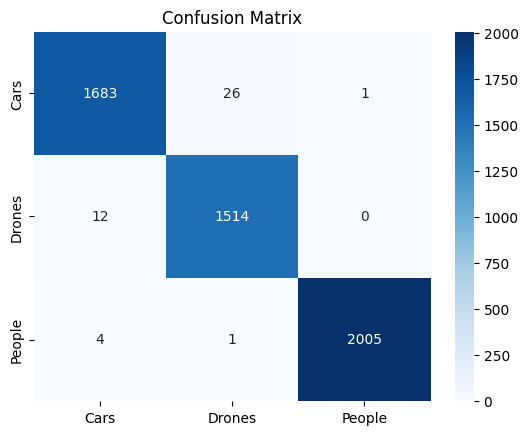

In [14]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()

- ### 6) Analise as métricas de desempenho, como acurácia, precisão, recall e F1-score, para cada classe (drone, carro e pessoa).

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print('Acurácia: {:.2f}'.format(accuracy))

precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average=None, labels=[0, 1, 2])
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average=None, labels=[0, 1, 2])
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average=None, labels=[0, 1, 2])

Acurácia: 0.99


In [17]:
for i, class_name in enumerate(classes):
    print('Classe: {}'.format(class_name))
    print('\tPrecisão: {:.2f}'.format(precision[i]))
    print('\tRecall: {:.2f}'.format(recall[i]))
    print('\tF1-Score: {:.2f}\n'.format(f1[i]))

Classe: Drone
	Precisão: 0.99
	Recall: 0.98
	F1-Score: 0.99

Classe: Carro
	Precisão: 0.98
	Recall: 0.99
	F1-Score: 0.99

Classe: Pessoa
	Precisão: 1.00
	Recall: 1.00
	F1-Score: 1.00



In [18]:
print('\nRelatório de Classificação:\n')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=classes))


Relatório de Classificação:

              precision    recall  f1-score   support

       Drone       0.99      0.98      0.99      1710
       Carro       0.98      0.99      0.99      1526
      Pessoa       1.00      1.00      1.00      2010

    accuracy                           0.99      5246
   macro avg       0.99      0.99      0.99      5246
weighted avg       0.99      0.99      0.99      5246



- ### 7) Visualize as previsões do modelo em amostras de dados de teste para entender melhor suas capacidades e limitações.

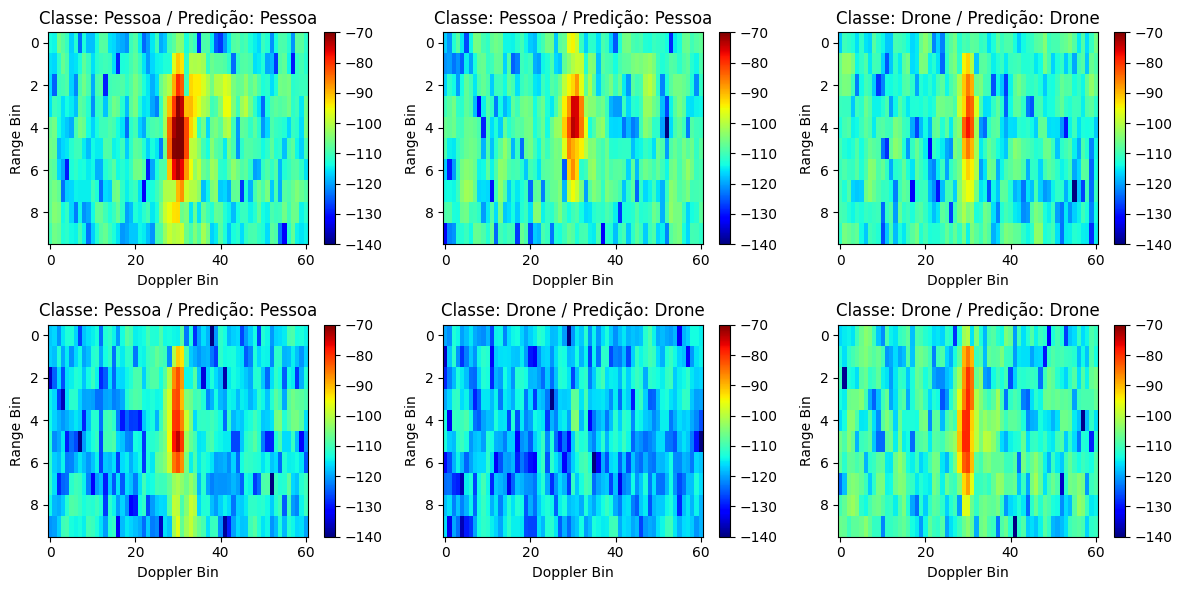

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    img = ax.imshow(list_of_img[i], vmin=-140, vmax=-70, cmap='jet')
    ax.set_title(f"Classe: {classes[np.argmax(y_test, axis=1)[i]]} / Predição: {classes[np.argmax(y_test, axis=1)[i]]}")
    ax.set_ylabel('Range Bin')
    ax.set_xlabel('Doppler Bin')
    ax.axis('tight')
    plt.colorbar(img, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()


- ### 8) Compare os resultados com os obtidos pelo sistema proposto no trabalho original para avaliar a eficácia do modelo em relação à referência.

- ### 9) Escolha uma das arquiteturas clássicas de CNN, treinadas com a Imagenet. Estes modelos podem ser encontrados em: link. Adapte os dados de entrada, se necessário, e verifique o desempenho obtido na classificação utilizando este novo modelo. Compare com o modelo encontrado inicialmente, considerando custo computacional e desempenho.

In [20]:
def ajust_image(images):
    images = tf.tile(images, [1, 1, 1, 3])
    return tf.image.resize(images, [224, 224], method='bilinear')

In [21]:
input_tensor = Input(shape=(10, 61, 1))
input_tensor = Lambda(ajust_image)(input_tensor)

# base_model = VGG19(
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
)

In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

##### Sem Transfer Learning

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
y_pred = model.predict(X_test, verbose=0)

In [25]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.00      0.00      0.00      1710
      Drones       0.00      0.00      0.00      1526
      People       0.38      1.00      0.55      2010

    accuracy                           0.38      5246
   macro avg       0.13      0.33      0.18      5246
weighted avg       0.15      0.38      0.21      5246



/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[]

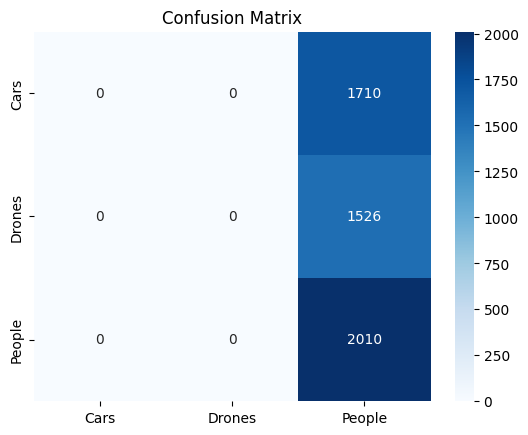

In [26]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()

##### Com Transfer Learning

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
_ = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


2024-05-28 16:00:39.883669: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 16:00:39.898273: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 16:00:39.915730: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 16:00:39.915819: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

383/383 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7199

2024-05-28 16:01:38.881942: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 16:01:38.896276: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 16:01:38.912432: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 16:01:38.912510: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

383/383 [==============================] - 61s 153ms/step - loss: 0.6499 - accuracy: 0.7199 - val_loss: 0.5039 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 2/20
383/383 [==============================] - 56s 147ms/step - loss: 0.4806 - accuracy: 0.7959 - val_loss: 0.4752 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 3/20
383/383 [==============================] - 56s 146ms/step - loss: 0.4649 - accuracy: 0.8002 - val_loss: 0.4442 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 4/20
383/383 [==============================] - 55s 145ms/step - loss: 0.4525 - accuracy: 0.8024 - val_loss: 0.4335 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 5/20
383/383 [==============================] - 57s 149ms/step - loss: 0.4374 - accuracy: 0.8118 - val_loss: 0.4408 - val_accuracy: 0.8137 - lr: 0.0010
Epoch 6/20
383/383 [==============================] - 55s 145ms/step - loss: 0.4247 - accuracy: 0.8181 - val_loss: 0.4250 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 7/20
383/383 [==============================] - 57s 148ms

In [31]:
y_pred = model.predict(X_test, verbose=0)

In [32]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.88      0.58      0.70      1710
      Drones       0.69      0.92      0.79      1526
      People       0.91      0.95      0.93      2010

    accuracy                           0.82      5246
   macro avg       0.83      0.82      0.81      5246
weighted avg       0.84      0.82      0.81      5246



[]

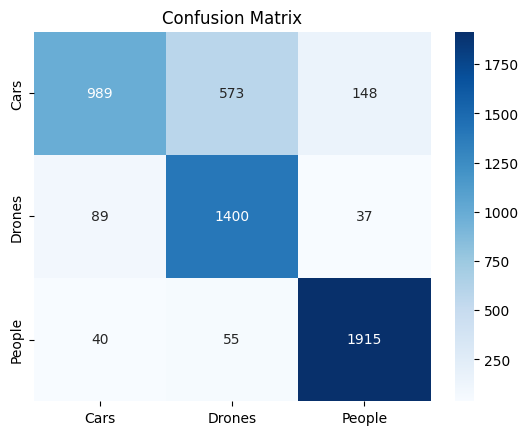

In [33]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()

##### Com Transfer Learning + Fining Tunning

In [34]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [35]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
_ = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
383/383 [==============================] - 52s 127ms/step - loss: 0.8565 - accuracy: 0.6350 - val_loss: 0.5040 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 2/20
383/383 [==============================] - 48s 126ms/step - loss: 0.3693 - accuracy: 0.8597 - val_loss: 0.3231 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 3/20
383/383 [==============================] - 48s 125ms/step - loss: 0.2918 - accuracy: 0.8877 - val_loss: 0.2775 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 4/20
383/383 [==============================] - 48s 126ms/step - loss: 0.2738 - accuracy: 0.8965 - val_loss: 0.2760 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 5/20
383/383 [==============================] - 48s 126ms/step - loss: 0.2377 - accuracy: 0.9098 - val_loss: 0.2524 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 6/20
383/383 [==============================] - 48s 126ms/step - loss: 0.2322 - accuracy: 0.9098 - val_loss: 0.2525 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 7/20
383/383 [==============================] 

In [38]:
y_pred = model.predict(X_test, verbose=0)

In [39]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.95      0.93      0.94      1710
      Drones       0.92      0.95      0.93      1526
      People       0.99      0.99      0.99      2010

    accuracy                           0.96      5246
   macro avg       0.95      0.96      0.95      5246
weighted avg       0.96      0.96      0.96      5246



[]

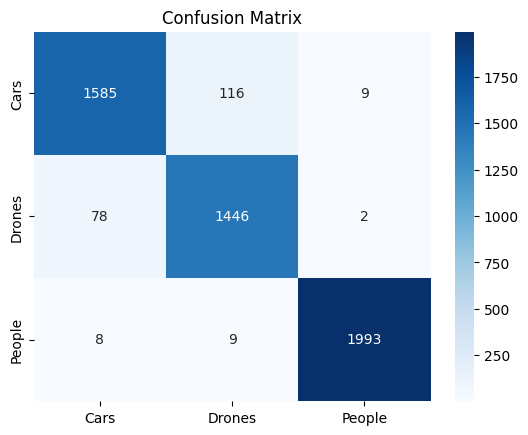

In [40]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()